### If players played 90 mins in all matches

$$
y \sim \textrm{Multinomial}(p_g,  p_a, p_0)
$$

where $p_g, p_a, p_0$ are the probabilities a player scores or assists a given goal (or does neither). $y$ is whether a player scored (1, 0, 0), assisted (0, 1, 0) or did neither (0, 0, 1) for a goal their team scores.

**Prior:**

$$
(p_g,  p_a, p_0) \sim \textrm{Dirichlet}(\alpha_g, \alpha_a, \alpha_0)
$$

where $\alpha_g, \alpha_a, \alpha_0$ are the priors for goals, assists and neither. The expected values are $\mathrm{E}[p_g] = \alpha_g / (\alpha_g + \alpha_a + \alpha_0)$ and so on, and the variance scales with the the $\alpha$ values (e.g. $\textrm{Dirichlet}(1, 1, 1)$ has higher variance than $\textrm{Dirichlet}(2, 2, 2)$).

**Posterior:**

As Dirichlet is a conjugate prior for the multinomial distribution, the posterior is also Dirichlet (see e.g. BDA3 Section 3.4 page 69, and [here](https://stephentu.github.io/writeups/dirichlet-conjugate-prior.pdf)):

$$
(p_g,  p_a, p_0) \sim \textrm{Dirichlet}(\alpha_g +n_g, \alpha_a + n_a, \alpha_0 + n_0)
$$

where $n_g, n_a, n_0$ are the total number of goals a player has scored or assisted, and the number of goals their team scored but they weren't involved in.



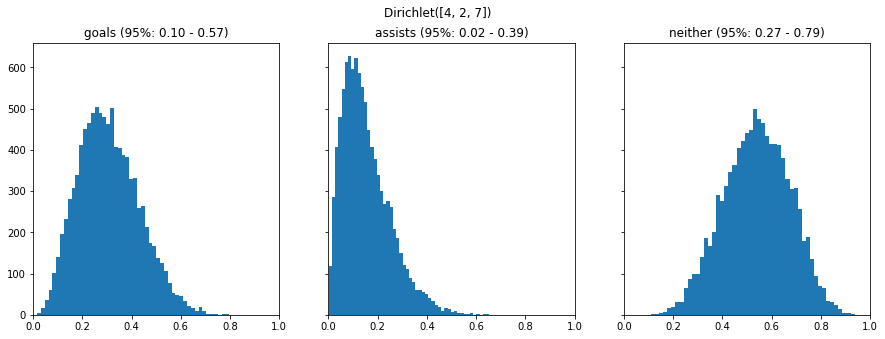

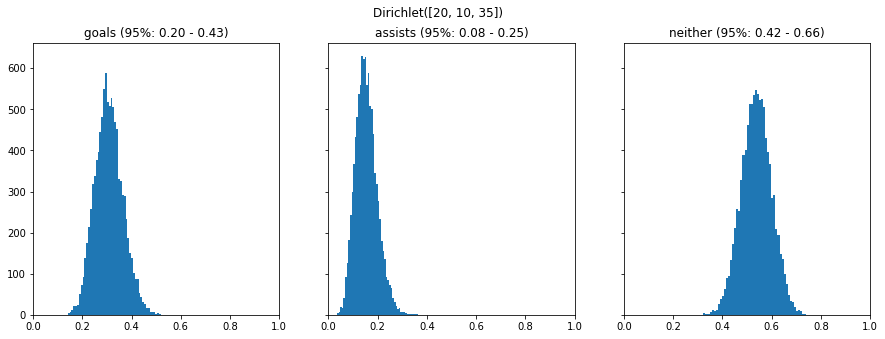

In [1]:
# Example Dirichlet distributions imagining a prior of 4 goals, 2 assists, 7 neither;  then a
# posterior with a player continuing at the same ratios to give 20 goals, 10 assists, 35  neither total.

from scipy.stats import dirichlet
import matplotlib.pyplot as plt
import numpy as np

def plot_dirichlet(a, n=10000, bins=50):
    dist = dirichlet(a)
    sample = dist.rvs(n)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    fig.suptitle(f"Dirichlet({a})")

    for i, name in enumerate(("goals", "assists", "neither")):
        ax[i].hist(sample[:, i], bins=bins)
        ax[i].set_title(
            f"{name} (95%: "
            f"{np.quantile(sample[:, i], 0.025):.2f} - "
            f"{np.quantile(sample[:, i], 0.975):.2f})"
        )
        ax[i].set_xlim((0, 1))

plot_dirichlet([4, 2, 7])
plot_dirichlet([20, 10, 35])


### Choice of $\alpha$ (Prior) and taking into account minutes - Previous Implementation

Previous AIrsenal prior (from `get_empirical_bayes_estimate`):
$$
\alpha_g = M \frac{N_g}{T_g} \frac{T_{mins}}{P_{mins}} \\
\alpha_a = M \frac{N_a}{T_g} \frac{T_{mins}}{P_{mins}} \\
\alpha_0 = M \left(\frac{N_0}{T_g} - \frac{T_{mins} - P_{mins}}{T_{mins}}\right) \frac{T_{mins}}{P_{mins}}
$$

where $M$ is the average number of matches played by players in a certain position (FWD/MID/DEF), $T_g$ is the total number of goals scored by the player's teams, $P_{mins}$ is the total number of minutes played by the players, and $T_{mins}$ is the total number of minutes played by the teams (90 * no. of matches), and the player and team stats are sums across all players in that position ($N_g$ rather than $n_g$ to indicate multiple players).

In words, $\alpha_g$ is: (no. matches played) * (fraction of goals scored) / (fraction of minutes played) across players in this position. So, effectively, estimated fraction of goals scored if players played full 90 mins in all matches, multiplied by no. matches.

- Fraction goals if playing full 90 mins is what we want to estimate (i.e. this is the $p_g$ term in $\theta$)
   - But I think it's more natural to use numbers of goals in the prior and posterior updating (as in sections above)

- Multiplication by no. of matches define strength of prior
   - But is using avg. no. matches a sensible choice? Is it too strong? Maybe something like having the prior equivalent to around 10 matches of data would make more sense?

When fitting the model the minutes are taken into account by scaling the goal probabilities:

$$
p_g = p_g \frac{m}{90} \\
p_a = p_a \frac{m}{90} \\
p_0 = p_0 \frac{m}{90} + \frac{90 - m}{90}
$$

where the $p_g, p_a, p_0$ values on the right are the original sampled probabilities sampled from the Dirichlet distribution and $m$ is the no. minutes played  by the player.

### Choice of $\alpha$ (Prior) and taking into account minutes - New Thoughts

For each player include only matches where:
- Player played at least 1 minute
   - player shouldn't be penalised for not being involved in goals when they weren't on the pitch
- Player's team scored at least 1 goal
   - matches without goals give no data on the probability of a player being involved in a goal their team scores

Limitation: We only know how many minutes a player played, how many goals they scored/assisted in the match, and how many goals their team scored/assisted in the match. We don't know _when_ goals were scored within the match, and critically we don't know how many goals the team scored when the player was on the pitch (if player played less than 90 mins). There's likely a data source where we could get this though (time goals scored and time subs came on/off)

To try to take this into account we can scale down the number of goals a player wasn't involved in by the fraction of the minutes they played:

$$
n_g = n_g \\
n_a = n_a \\
n_0 = T_g \frac{P_{mins}}{T_{mins}} - n_g - n_a
$$

where $T_g$ is the total number of goals scored by the player's team, $P_{mins}$ is the total number of minutes played by the player, and $T_{mins}$ is the total number of minutes played by the team (90 * no. of matches meeting the criteria above).

It's possible for $n_0$ to be negative (also true for $\alpha_0$ in the old implementation) for players that were involved in an unusually large number of goals for the number of minutes they played. These should be set to zero?

**Prior**
- Use $N_g$, $N_a$, $N_0$ as defined above but summed across all players in the position ($N_g = \sum n_g$ etc.)
- Pick a number of goals equivalent for the prior to sum to: $G = \alpha_g + \alpha_a + \alpha_0$
   - Suggest 13 goals, which is roughly average no. of goals scored by teams in 10 matches (2020/21 season).
   - Idea being that after 10 matches we should have a pretty good idea of their goal threat.

$$
\alpha_g = \frac{G N_g}{N_g + N_a + N_0} \\
\alpha_a = \frac{G N_a}{N_g + N_a + N_0} \\
\alpha_0 = \frac{G N_0}{N_g + N_a + N_0}
$$

Note these have units of goals (which is not the case for our original prior).

**Posterior**
-  As in the conjugate model:

$$
(p_g,  p_a, p_0) \sim \textrm{Dirichlet}(\alpha_g +n_g, \alpha_a + n_a, \alpha_0 + n_0)
$$

Don't need to sample to get the means, can compute them directly e.g.:
$$
\textrm{E}[p_g] = \frac{\alpha_g +n_g}{\alpha_g +n_g + \alpha_a + n_a + \alpha_0 + n_0}
$$

### Implementation

In [2]:
from airsenal.framework.prediction_utils import process_player_data
from airsenal.framework.player_model import scale_goals_by_minutes
from airsenal.framework.utils import get_player, fastcopy
from airsenal.framework.player_model import ConjugatePlayerModel, NumpyroPlayerModel
import pandas as pd

data_fwd = process_player_data("FWD")
data_mid = process_player_data("MID")
data_def = process_player_data("DEF")

conj_model_fwd = ConjugatePlayerModel().fit(data_fwd, n_goals_prior=13)
conj_model_mid = ConjugatePlayerModel().fit(data_mid, n_goals_prior=13)
conj_model_def = ConjugatePlayerModel().fit(data_def, n_goals_prior=13)


def get_model_df(model):
    df = pd.DataFrame(model.get_probs())
    df["player_name"] = df["player_id"].apply(lambda x: get_player(x).name)
    return df


def display_model(df, n_display=5):
    for c in ("prob_score", "prob_assist"):  #, "prob_neither"):
        sort_ascending = True if c == "prob_neither" else False
        display(df.sort_values(by=c, ascending=sort_ascending).head(n_display))


conj_fwd = get_model_df(conj_model_fwd)
conj_mid = get_model_df(conj_model_mid)
conj_def = get_model_df(conj_model_def)


Filling history dataframe for Harry Kane: 0/76 done
Filling history dataframe for Romelu Lukaku: 1/76 done
Filling history dataframe for Jamie Vardy: 2/76 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/76 done
Filling history dataframe for Roberto Firmino: 4/76 done
Filling history dataframe for Timo Werner: 5/76 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/76 done
Filling history dataframe for Edinson Cavani: 7/76 done
Filling history dataframe for Alexandre Lacazette: 8/76 done
Filling history dataframe for Danny Ings: 9/76 done
Filling history dataframe for Dominic Calvert-Lewin: 10/76 done
Filling history dataframe for Patrick Bamford: 11/76 done
Filling history dataframe for Anthony Martial: 12/76 done
Filling history dataframe for Michail Antonio: 13/76 done
Filling history dataframe for Richarlison de Andrade: 14/76 done
Filling history dataframe for Callum Wilson: 15/76 done
Filling history dataframe for Raúl Jiménez: 16/76 done
Filling histo

Filling history dataframe for Luka Milivojevic: 118/236 done
Filling history dataframe for Thiago Alcántara do Nascimento: 119/236 done
Filling history dataframe for Takumi Minamino: 120/236 done
Filling history dataframe for Ryan Fraser: 121/236 done
Filling history dataframe for Kieran Dowell: 122/236 done
Filling history dataframe for Imrân Louza: 123/236 done
Filling history dataframe for Andriy Yarmolenko: 124/236 done
Filling history dataframe for Granit Xhaka: 125/236 done
Filling history dataframe for Thomas Partey: 126/236 done
Filling history dataframe for Albert Sambi Lokonga: 127/236 done
Filling history dataframe for Reiss Nelson: 128/236 done
Filling history dataframe for Conor Hourihane: 129/236 done
Filling history dataframe for Morgan Sanson: 130/236 done
Filling history dataframe for Jaden Philogene-Bidace: 131/236 done
Filling history dataframe for Christian Nørgaard: 132/236 done
Filling history dataframe for Vitaly Janelt: 133/236 done
Filling history dataframe for

Filling history dataframe for Matthew Cash: 30/194 done
Filling history dataframe for Ezri Konsa Ngoyo: 31/194 done
Filling history dataframe for Ashley Young: 32/194 done
Filling history dataframe for Lewis Dunk: 33/194 done
Filling history dataframe for James Tarkowski: 34/194 done
Filling history dataframe for Ben Mee: 35/194 done
Filling history dataframe for Andreas Christensen: 36/194 done
Filling history dataframe for Malang Sarr: 37/194 done
Filling history dataframe for Trevoh Chalobah: 38/194 done
Filling history dataframe for Seamus Coleman: 39/194 done
Filling history dataframe for Michael Keane: 40/194 done
Filling history dataframe for Yerry Mina: 41/194 done
Filling history dataframe for Çaglar Söyüncü: 42/194 done
Filling history dataframe for James Justin: 43/194 done
Filling history dataframe for Jannik Vestergaard: 44/194 done
Filling history dataframe for Héctor Junior Firpo Adames: 45/194 done
Filling history dataframe for Joel Matip: 46/194 done
Filling history da

In [3]:
display_model(conj_fwd)

,player_id,prob_score,prob_assist,prob_neither,player_name
7,56,0.415878,0.096187,0.487935,Danny Ings
42,362,0.383568,0.125351,0.491081,Teemu Pukki
17,123,0.368897,0.081778,0.549324,Chris Wood
14,111,0.367978,0.086078,0.545944,Florin Andone
0,4,0.365803,0.106526,0.527670,Pierre-Emerick Aubameyang


,player_id,prob_score,prob_assist,prob_neither,player_name
21,150,0.149408,0.213132,0.637460,Timo Werner
6,51,0.253611,0.206054,0.540335,Keinan Davis
47,398,0.231919,0.205824,0.562257,Che Adams
38,339,0.304337,0.203004,0.492659,Callum Wilson
40,350,0.149343,0.197596,0.653061,Allan Saint-Maximin


In [4]:
display_model(conj_mid)

,player_id,prob_score,prob_assist,prob_neither,player_name
115,267,0.277709,0.133284,0.589007,Mohamed Salah
137,315,0.270812,0.208299,0.520889,Bruno Miguel Borges Fernandes
118,274,0.268476,0.117118,0.614406,Diogo Jota
178,417,0.265523,0.209050,0.525427,Heung-Min Son
19,44,0.246212,0.095931,0.657857,Anwar El Ghazi


,player_id,prob_score,prob_assist,prob_neither,player_name
149,341,0.098184,0.254310,0.647506,Ryan Fraser
123,287,0.130034,0.228509,0.641456,Kevin De Bruyne
39,88,0.108012,0.222432,0.669555,Pascal Groß
217,513,0.168344,0.221570,0.610086,Pedro Lomba Neto
72,176,0.126096,0.218658,0.655246,Eberechi Eze


In [5]:
display_model(conj_def)

,player_id,prob_score,prob_assist,prob_neither,player_name
29,89,0.119017,0.043187,0.837796,Shane Duffy
114,336,0.109759,0.011724,0.878517,Ciaran Clark
119,348,0.104041,0.037753,0.858206,Fabian Schär
128,381,0.099554,0.048781,0.851665,Ben Gibson
190,1186,0.087109,0.042683,0.870207,Trevoh Chalobah


,player_id,prob_score,prob_assist,prob_neither,player_name
113,335,0.050775,0.181236,0.767988,Matt Ritchie
144,426,0.054911,0.176240,0.768850,Ryan Sessegnon
38,114,0.007911,0.174446,0.817643,Erik Pieters
89,271,0.032664,0.166475,0.800861,Trent Alexander-Arnold
65,189,0.031620,0.163239,0.805141,Lucas Digne


In [6]:
conj_fwd.describe()

,player_id,prob_score,prob_assist,prob_neither
count,76.000000,76.000000,76.000000,76.000000
mean,333.171053,0.279187,0.136954,0.583859
std,254.652620,0.052916,0.034414,0.057495
min,4.000000,0.139025,0.053895,0.487935
25%,133.250000,0.259038,0.119143,0.547947
50%,327.500000,0.282294,0.136784,0.579695
75%,455.500000,0.306774,0.158925,0.608956
max,1191.000000,0.415878,0.213132,0.777672


PRIOR


,player_id,prob_score,prob_assist,prob_neither
count,76.000000,76.000000,76.000000,76.000000
mean,333.171053,0.279187,0.136954,0.583859
std,254.652620,0.052916,0.034414,0.057495
min,4.000000,0.139025,0.053895,0.487935
25%,133.250000,0.259038,0.119143,0.547947
50%,327.500000,0.282294,0.136784,0.579695
75%,455.500000,0.306774,0.158925,0.608956
max,1191.000000,0.415878,0.213132,0.777672


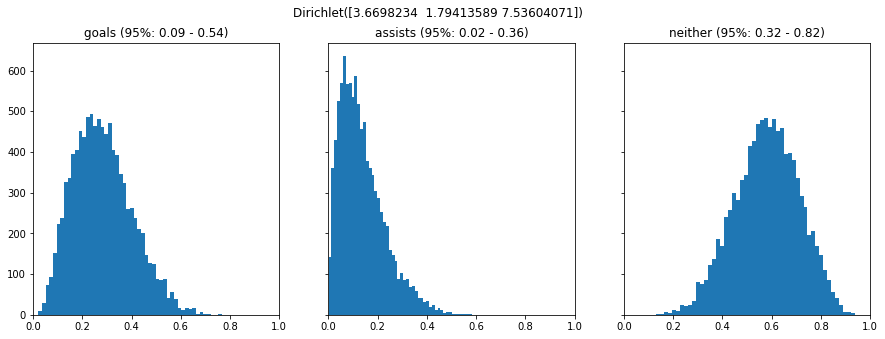

In [7]:
print("PRIOR")
plot_dirichlet(conj_model_fwd.prior.reshape(3))
conj_fwd.describe()
# note that prior spans wider range than data (e.g. min 0.14 max 0.42 prob_score in data,
# compared to 0.08 - 0.53 95% interval in 13 goal prior)
# - is this then too weak of a prior?

ADAM ARMSTRONG


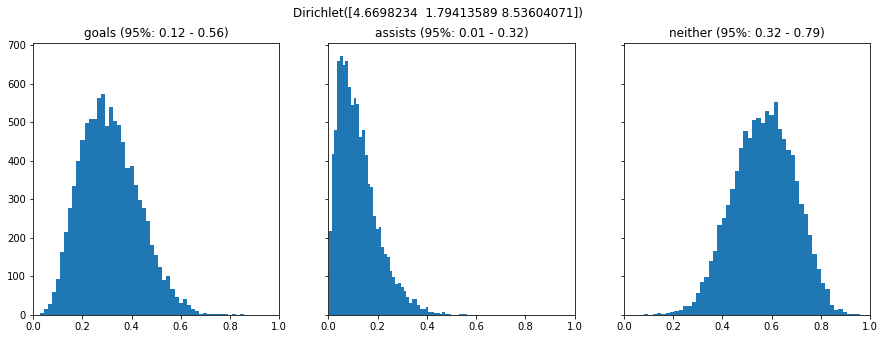

In [8]:
print("ADAM ARMSTRONG")
aa_id = get_player("Adam Armstrong").player_id
plot_dirichlet(conj_model_fwd.posterior[conj_model_fwd.player_ids == aa_id].reshape(3))

PATRICK BAMFORD


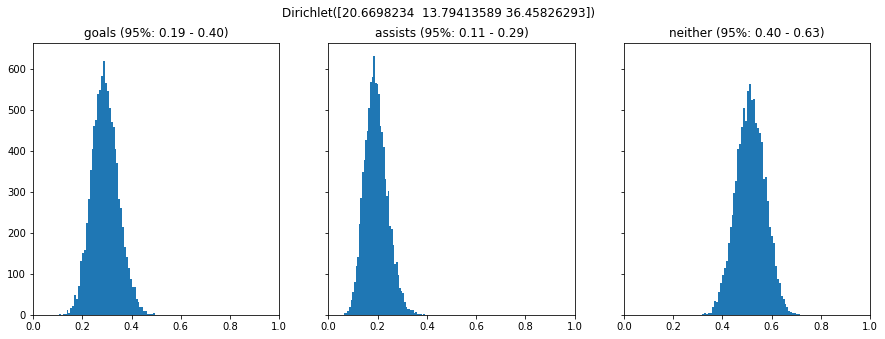

In [9]:
print("PATRICK BAMFORD")
aa_id = get_player("Patrick Bamford").player_id
plot_dirichlet(conj_model_fwd.posterior[conj_model_fwd.player_ids == aa_id].reshape(3))

JAMIE VARDY


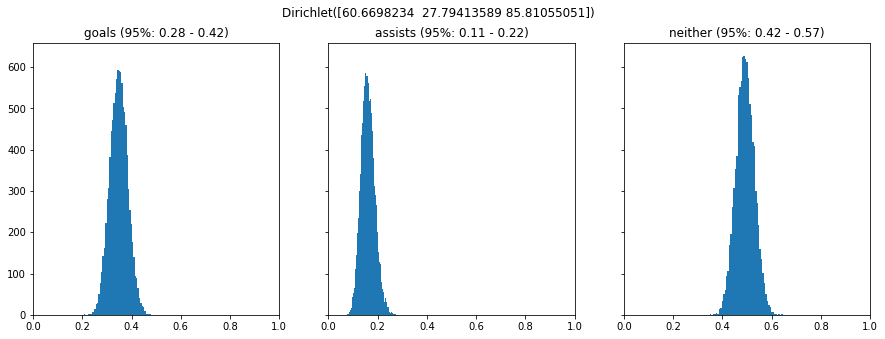

In [10]:
print("JAMIE VARDY")
jv_id = get_player("Jamie Vardy").player_id
plot_dirichlet(conj_model_fwd.posterior[conj_model_fwd.player_ids == jv_id].reshape(3))

### Comparison with Numpyro

In [11]:
np_model_fwd = NumpyroPlayerModel().fit(data_fwd)
np_model_mid = NumpyroPlayerModel().fit(data_mid)
np_model_def = NumpyroPlayerModel().fit(data_def)

np_fwd = get_model_df(np_model_fwd)
np_mid = get_model_df(np_model_mid)
np_def = get_model_df(np_model_def)


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 109.93it/s, 15 steps of size 3.02e-01. acc. prob=0.83]


In [12]:
def get_diff_df(np_df, conj_df):
    diff = pd.DataFrame(
        {
            "player_id": conj_df["player_id"],
            "player_name": conj_df["player_name"],
            "conj_score": conj_df["prob_score"],
            "np_score": np_df["prob_score"],
            "conj_assist": conj_df["prob_assist"],
            "np_assist": np_df["prob_assist"],
            "conj_neither": conj_df["prob_neither"],
            "np_neither": np_df["prob_neither"],
        }
    )
    diff["diff_score"] = diff["np_score"] - diff["conj_score"]
    diff["diff_assist"] = diff["np_assist"] - diff["conj_assist"]
    diff["diff_neither"] = diff["np_neither"] - diff["conj_neither"]
    return diff


fwd_diff = get_diff_df(np_fwd, conj_fwd)
mid_diff = get_diff_df(np_mid, conj_mid)
def_diff = get_diff_df(np_def, conj_def)

,player_id,player_name,conj_score,np_score,conj_assist,np_assist,conj_neither,np_neither,diff_score,diff_assist,diff_neither
42,362,Teemu Pukki,0.383568,0.342865,0.125351,0.140867,0.491081,0.516268,-0.040703,0.015516,0.025187
14,111,Florin Andone,0.367978,0.330937,0.086078,0.134830,0.545944,0.534233,-0.037041,0.048752,-0.011711
62,473,Juan Camilo Hernández Suárez,0.333559,0.302977,0.128153,0.141407,0.538289,0.555616,-0.030582,0.013255,0.017327
25,175,Jean-Philippe Mateta,0.319912,0.302677,0.122909,0.139235,0.557179,0.558087,-0.017234,0.016326,0.000908
74,1188,Adam Armstrong,0.311322,0.298085,0.119609,0.137643,0.569069,0.564273,-0.013237,0.018034,-0.004797
...,...,...,...,...,...,...,...,...,...,...,...
56,455,Isaac Success Ajayi,0.174403,0.288273,0.104352,0.148344,0.721244,0.563384,0.113869,0.043991,-0.157861
40,350,Allan Saint-Maximin,0.149343,0.265663,0.197596,0.213080,0.653061,0.521257,0.116320,0.015484,-0.131803
24,169,Jordan Ayew,0.169775,0.292354,0.136495,0.187148,0.693730,0.520498,0.122579,0.050653,-0.173232
50,409,Shane Long,0.193933,0.318584,0.123489,0.175768,0.682578,0.505648,0.124651,0.052279,-0.176930


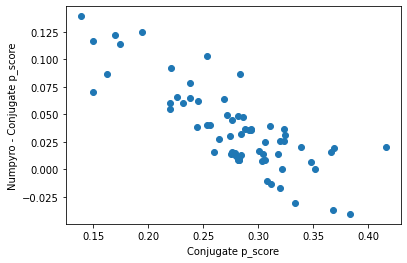

In [13]:
plt.plot(fwd_diff["conj_score"], fwd_diff["diff_score"], "o")
plt.xlabel("Conjugate p_score")
plt.ylabel("Numpyro - Conjugate p_score")
fwd_diff.sort_values(by="diff_score")

,player_id,player_name,conj_score,np_score,conj_assist,np_assist,conj_neither,np_neither,diff_score,diff_assist,diff_neither
161,372,Todd Cantwell,0.222733,0.160013,0.101994,0.111270,0.675274,0.728716,-0.062719,0.009277,0.053443
203,481,Andriy Yarmolenko,0.229373,0.178752,0.119802,0.128602,0.650825,0.692646,-0.050621,0.008799,0.041821
11,26,Gabriel Teodoro Martinelli Silva,0.202715,0.152675,0.107288,0.115163,0.689997,0.732162,-0.050041,0.007875,0.042165
154,355,Matthew Longstaff,0.172258,0.125512,0.070401,0.097386,0.757341,0.777102,-0.046746,0.026985,0.019761
28,65,Sergi Canós,0.161288,0.118764,0.093164,0.104448,0.745548,0.776787,-0.042524,0.011285,0.031239
...,...,...,...,...,...,...,...,...,...,...,...
74,184,Fabian Delph,0.025782,0.077774,0.043550,0.087315,0.930668,0.834911,0.051992,0.043765,-0.095757
58,141,Mateo Kovacic,0.020296,0.072829,0.070449,0.121997,0.909255,0.805174,0.052533,0.051548,-0.104081
185,431,Oliver Skipp,0.052430,0.105443,0.051623,0.104675,0.895947,0.789883,0.053012,0.053052,-0.106064
184,430,Giovani Lo Celso,0.044089,0.098344,0.098362,0.131506,0.857548,0.770150,0.054255,0.033143,-0.087398


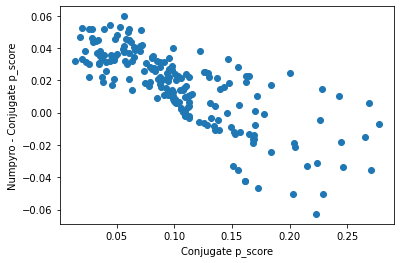

In [14]:
plt.plot(mid_diff["conj_score"], mid_diff["diff_score"], "o")
plt.xlabel("Conjugate p_score")
plt.ylabel("Numpyro - Conjugate p_score")
mid_diff.sort_values(by="diff_score")

,player_id,player_name,conj_score,np_score,conj_assist,np_assist,conj_neither,np_neither,diff_score,diff_assist,diff_neither
128,381,Ben Gibson,0.099554,0.043809,0.048781,0.052122,0.851665,0.904069,-0.055745,0.003341,0.052404
190,1186,Trevoh Chalobah,0.087109,0.042142,0.042683,0.050420,0.870207,0.907438,-0.044967,0.007736,0.037231
29,89,Shane Duffy,0.119017,0.077222,0.043187,0.048422,0.837796,0.874357,-0.041795,0.005235,0.036560
114,336,Ciaran Clark,0.109759,0.073184,0.011724,0.034168,0.878517,0.892648,-0.036575,0.022444,0.014131
119,348,Fabian Schär,0.104041,0.075838,0.037753,0.048554,0.858206,0.875608,-0.028203,0.010802,0.017401
...,...,...,...,...,...,...,...,...,...,...,...
182,573,Emerson Palmieri dos Santos,0.009915,0.023291,0.017198,0.040338,0.972887,0.936372,0.013375,0.023140,-0.036515
117,345,Javier Manquillo,0.006842,0.020278,0.081379,0.071890,0.911779,0.907832,0.013435,-0.009488,-0.003947
107,317,Alex Nicolao Telles,0.012758,0.026407,0.086931,0.068639,0.900311,0.904953,0.013649,-0.018291,0.004642
63,183,Nathaniel Clyne,0.007463,0.021461,0.050850,0.057205,0.941687,0.921335,0.013998,0.006355,-0.020353


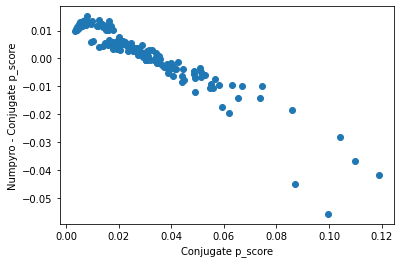

In [15]:
plt.plot(def_diff["conj_score"], def_diff["diff_score"], "o")
plt.xlabel("Conjugate p_score")
plt.ylabel("Numpyro - Conjugate p_score")
def_diff.sort_values(by="diff_score")

In [16]:
fwd_diff[fwd_diff.player_name == "Roberto Firmino"]

,player_id,player_name,conj_score,np_score,conj_assist,np_assist,conj_neither,np_neither,diff_score,diff_assist,diff_neither
33,262,Roberto Firmino,0.162334,0.249011,0.125458,0.170134,0.712208,0.580855,0.086677,0.044676,-0.131353


In [23]:
fwd_diff[fwd_diff.player_name == "Joelinton Cássio Apolinário de Lira"]

,player_id,player_name,conj_score,np_score,conj_assist,np_assist,conj_neither,np_neither,diff_score,diff_assist,diff_neither
41,353,Joelinton Cássio Apolinário de Lira,0.139025,0.278245,0.083303,0.149467,0.777672,0.572288,0.13922,0.066163,-0.205383


### Varying n_goals_prior in Conjugate Model

In [17]:
prob_dfs = {}
goals = range(1, 80, 5)
prob_score = np.zeros((len(goals), len(data_fwd["y"])))
for i, ng in enumerate(goals):
    m = ConjugatePlayerModel().fit(data_fwd, n_goals_prior=ng)
    prob_dfs[ng] = get_model_df(m)
    prob_score[i, :] = prob_dfs[ng]["prob_score"]


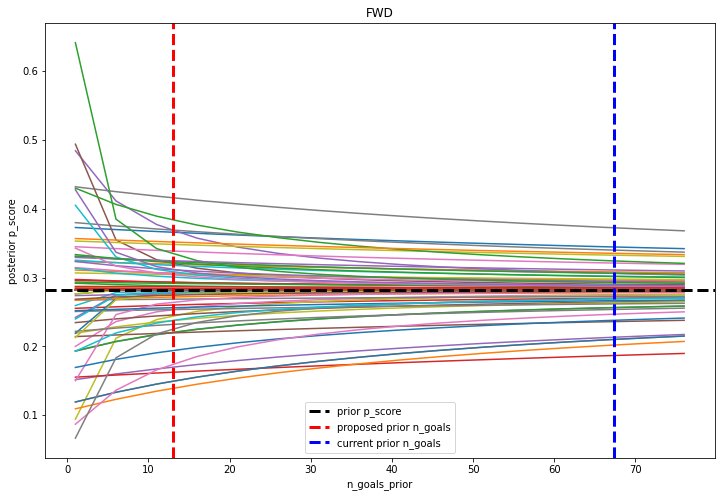

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(goals, prob_score)
plt.axhline(
    conj_model_fwd.prior[0] / conj_model_fwd.prior.sum(),
    color="k",
    linewidth=3,
    linestyle="--",
    label="prior p_score"
)
plt.axvline(
    13,
    color="r",
    linewidth=3,
    linestyle="--",
    label="proposed prior n_goals",
)
plt.axvline(
    data_fwd["alpha"].sum(),
    color="b",
    linewidth=3,
    linestyle="--",
    label="current prior n_goals",
)
plt.xlabel("n_goals_prior")
plt.ylabel("posterior p_score")
plt.title("FWD")
plt.legend()

There are some unexpected results in the numpyro model compared to the conjugate model, even when using a prior in the conjugate model slightly stronger than the prior in the numpyro model:

In [19]:
# Firmino 25% prob_score in numpyro model. Probability in conjugate model is much lower even with a stronger prior.
prob_dfs[goals[-1]][prob_dfs[goals[-1]].player_name == "Roberto Firmino"]

,player_id,prob_score,prob_assist,prob_neither,player_name
33,262,0.18966,0.128317,0.682023,Roberto Firmino


In [20]:
# Joelinton 28% prob_score in numpyro model. Probability in conjugate model is much lower even with a stronger prior.
prob_dfs[goals[-1]][prob_dfs[goals[-1]].player_name == "Joelinton Cássio Apolinário de Lira"]

,player_id,prob_score,prob_assist,prob_neither,player_name
41,353,0.207117,0.109304,0.683578,Joelinton Cássio Apolinário de Lira
